## Import libraries. Load cleaned dataset.

In [48]:
library(tidyverse)
library(readr) # Read in datasets.
options(scipen = 9999)
library(ggthemes) # Themes for ggplot2.
library(ggimage) # Supports images in ggplot2.
library(gt) # Create tables.

In [3]:
arena <- read_csv(file = "C:/Users/chris/Desktop/arena_clean.csv",
                          show_col_types = FALSE)

## Compute overall win rate.

In [4]:
overall_win_pct <- round(sum(arena$winLoss == 1)/length(arena$winLoss),3)
overall_win_pct

[1] 0.504

## Group data by matchup. Mutate columns for match performance and class icons.

In [5]:
arena_chart <- arena %>%
    group_by(enemyTeamComp) %>%
    summarize(wins = sum(winLoss == 1),
              losses = sum(winLoss == 0),
              total = n(),
              teamClassIcon1 = last(teamClassIcon1),
              teamClassIcon2 = last(teamClassIcon2),
              enemyTeamClassIcon1 = last(enemyTeamClassIcon1),
              enemyTeamClassIcon2 = last(enemyTeamClassIcon2)) %>%
    mutate(win_pct = round(wins/total,3),
           win_diff = win_pct - overall_win_pct) %>%
    filter(total >= 10) %>%
    arrange(-total)

## Create bar chart showing favored/unfavored matchups. 

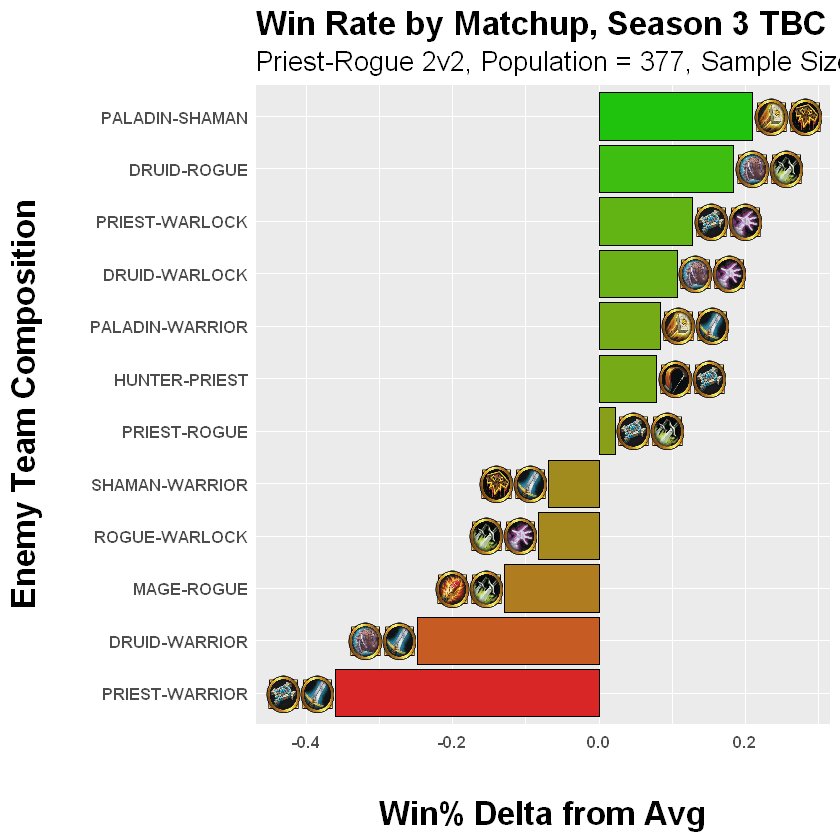

In [87]:
ggplot(arena_chart, aes(fill = win_diff, y = reorder(enemyTeamComp, win_diff), x = win_diff)) + 
    geom_bar(stat="identity", color="black") +
    scale_fill_gradient(low="#D82626", high="#1FC30E") +
    geom_image(aes(image=enemyTeamClassIcon1, 
                   x = ifelse(win_diff > 0, win_diff + 0.025, win_diff - 0.0715), 
                   y = enemyTeamComp), size=.06) +
    geom_image(aes(image=enemyTeamClassIcon2, 
                   x = ifelse(win_diff > 0, win_diff + 0.0715, win_diff - 0.025), 
                   y = enemyTeamComp), size=.06) +
    theme(axis.text.x = element_text(face="bold", vjust=0.5, hjust=0.5, size=10, angle=0),
          axis.text.y = element_text(face="bold", vjust=0.5, hjust=1, size=10, angle=0),
          axis.ticks = element_blank(),
          axis.title.x = element_text(face="bold", size=20, margin=margin(t=30)),
          axis.title.y = element_text(face="bold", size=20, margin=margin(r=30)),
          plot.title = element_text(face="bold", size=20),
          plot.subtitle = element_text(size = 16),
          legend.position = "none") +
    labs(title = "Win Rate by Matchup, Season 3 TBC",
         subtitle = "Priest-Rogue 2v2, Population = 377, Sample Size n > 10",
         x = "Win% Delta from Avg",
         y = "Enemy Team Composition")

In [88]:
ggsave("tbc-arena-winrate-delta.png", width=15, height=10, dpi="retina")

## Group data by matchup. Add column for match duration.

In [66]:
arena_gt <- arena %>%
    group_by(enemyTeamComp) %>%
    summarize(wins = sum(winLoss == 1),
              losses = sum(winLoss == 0),
              total = n(),
              avg_duration = paste(mean(duration)%/%60, sprintf("%02d",round(mean(duration)%%60,0)), sep=":"),
              enemyTeamClassIcon1 = last(enemyTeamClassIcon1),
              enemyTeamClassIcon2 = last(enemyTeamClassIcon2)
             ) %>%
    mutate(win_pct = round(wins/total,3)) %>%
    filter(total >= 10) %>%
    arrange(-total)
arena_gt <- arena_gt[, c(6, 7, 1, 4, 2, 3, 8, 5)]

## Create table showing individual matchup overview.

In [103]:
arena_gt_chart <- arena_gt %>%
    gt() %>%
    cols_label(enemyTeamComp = "Matchup",
               total = "Games Played",
               wins = "Wins",
               losses = "Losses",
               win_pct = "Win %",
               avg_duration = "Avg. Duration",
               enemyTeamClassIcon1 = "",
               enemyTeamClassIcon2 = "") %>%
    cols_align(align = "center",
               columns = c(total, wins, losses, win_pct, avg_duration)) %>%
    gtExtras::gt_img_rows(enemyTeamClassIcon1) %>%
    gtExtras::gt_img_rows(enemyTeamClassIcon2) %>%
    gtExtras::gt_theme_espn() %>%
    tab_header(title = "Priest-Rogue Matchups",
               subtitle = "TBC Season 3, Population = 377") %>%
    tab_options(heading.title.font.size = 30,
                heading.subtitle.font.size = 16,
                heading.border.bottom.color = "#808080") %>%
    tab_style(style = cell_borders(sides = "right",
                                   color = "#D3D3D3",
                                   weight = px(2)),
              locations = cells_body(columns = c(enemyTeamComp),
                                     rows = everything())) %>%
    data_color(columns = win_pct,
               colors = scales::col_numeric(palette = c("#ff0000", "#ffc100", "#A9F36A", "#78EC6C", "#57E86B"),
                                            domain = c(0, 1)))

In [104]:
gtsave(arena_gt_chart, "priest-rogue-matchups-s3.png")

## Create scatterplot showing rating over time.

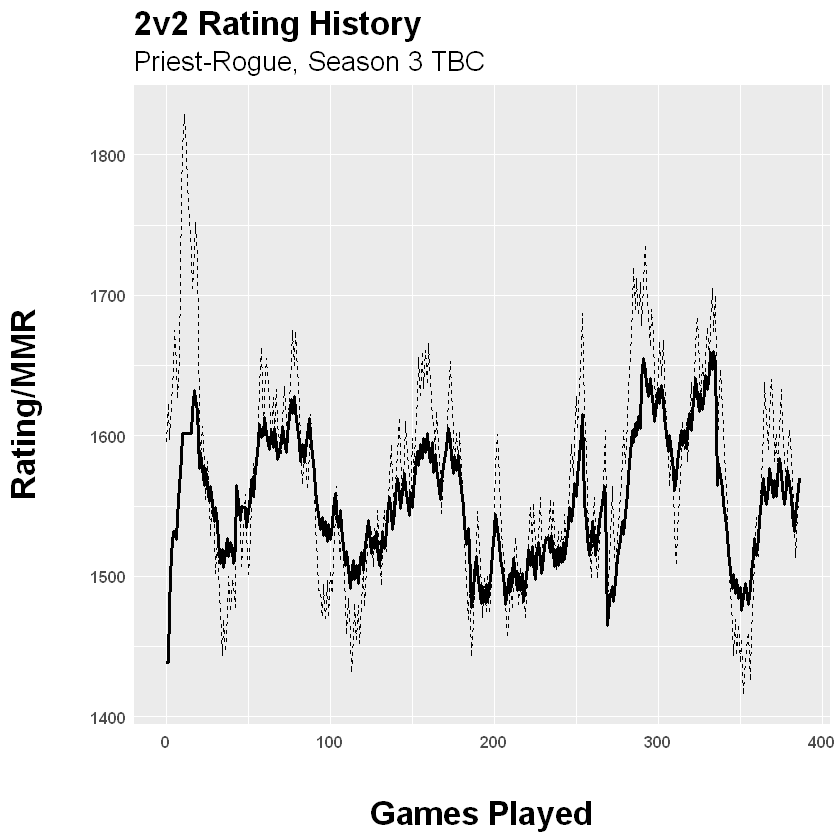

In [113]:
ggplot() + 
    geom_line(data = arena,
              aes(x = index, y = mmr),
              size = .25,
              linetype = "dashed") +
    geom_line(data = arena,
              aes(x = index, y = newTeamRating),
              size = 1) +
    theme(axis.text.x = element_text(face="bold", vjust=0.5, hjust=0.5, size=10, angle=0),
          axis.text.y = element_text(face="bold", vjust=0.5, hjust=1, size=10, angle=0),
          axis.ticks = element_blank(),
          axis.title.x = element_text(face="bold", size=20, margin=margin(t=30)),
          axis.title.y = element_text(face="bold", size=20, margin=margin(r=30)),
          plot.title = element_text(face="bold", size=20),
          plot.subtitle = element_text(size = 16),
          legend.position = "none") +
    labs(title = "2v2 Rating History",
         subtitle = "Priest-Rogue, Season 3 TBC",
         x = "Games Played",
         y = "Rating/MMR")

In [114]:
ggsave("tbc-rating-scatter.png", width=15, height=10, dpi="retina")